0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


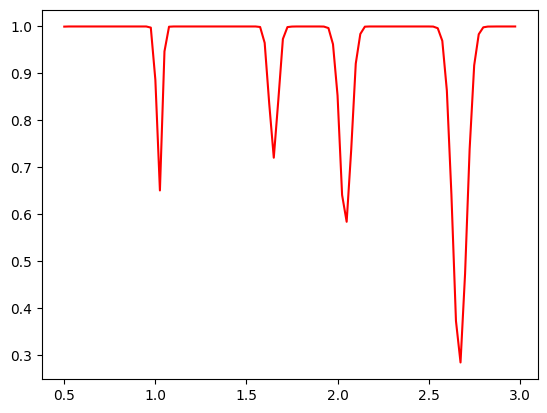

In [39]:

import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Qiskit Runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit.circuit.library import MCPhaseGate
import numpy as np
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt




N = 3
N_tau = 100

alpha = np.pi/2
jump = 2
N_reg = np.floor(np.log2(N_tau))+1
all = []
for i in range(N):
    all.append(i)

realdim = pow(2,N-1)+1
dim = pow(2,N)


j = np.arange(realdim).reshape(realdim, 1)  # Column vector of indices
k = np.arange(realdim).reshape(1, realdim)  # Row vector of indices
    
    # Compute the exponent matrix
exponent = 2 * np.pi * 1j * j * k / realdim
    
    # Compute Q matrix
DFT = np.exp(exponent) / np.sqrt(realdim)
DFTdag = np.exp(-exponent) / np.sqrt(realdim)


U = np.identity(dim, dtype=complex)
Udag = np.identity(dim, dtype=complex)
# Replace the upper-left 3x3 block with DFT_3
U[:realdim, :realdim] = DFT
Udag[:realdim, :realdim] = DFTdag


U_op = Operator(U)

Udag_op = Operator(Udag)


def trial(qc,graph, meas_site, ancilla, measures, N,jump,dim, realdim,N_tau, t, N_reg, all, N_trials ):
    
    qc.unitary(U_op, all, label='DFT_3')

    eig = []
    for i in range(realdim):
        lam = 0
        for j in range(1,jump+1):
            lam += 2*np.cos(2*np.pi*i*j/realdim+alpha)
        eig.append(lam)


    binary = [0]*N #number written from sx to dx
    for i in range(realdim-1):

        num = i
        for j in reversed(range(N)):
            binary[j] = (num-num%2**j)/2**j
            num = num-binary[j]*2**j
            
        for j in range(N):
            if binary[j] ==0:
                qc.x(j)

        mc_phase_gate = MCPhaseGate(-t*eig[i], num_ctrl_qubits=N-1)
        qc.append(mc_phase_gate,all)

        for j in range(N):
            if binary[j] == 0:
                qc.x(j)

    for i in range(N-1):
        qc.x(i)

    mc_phase_gate = MCPhaseGate(-t*eig[realdim-1], num_ctrl_qubits=N-1)
    qc.append(mc_phase_gate,all)
    for i in range(N-1):
        qc.x(i)

    
    qc.unitary(Udag_op, all, label='inv_DFT_3')
 
    qc.measure(meas_site, mid_measure)
    
    binary_array = [int(bit) for bit in bin(N_trials)[:1:-1]]
    for i in range(len(binary_array)):
        if binary_array[i] ==0:
            qc.measure(ancilla, readout[i])
        else:
            qc.x(ancilla)
            qc.measure(ancilla, readout[i])
            qc.x(ancilla)

def reverse_and_convert_to_decimal(bitstring_):
        
    decimal_value = 0
    length = len(bitstring_)
   
     # Traverse the string from right to left and convert each bit to decimal
    for i in range(length):
        if bitstring_[length-1- i] == '1':
            decimal_value += 2 ** i
    
                
    return decimal_value


times_run = 10000
simulator = AerSimulator()
N_mesh = 100
tmin = 0.5
tmax = 3
time = ((tmax-tmin)/N_mesh)*np.array(range(N_mesh))+tmin
res_mean  = []
res_prob  = []


for it in range(N_mesh):
    t  = time[it]


    graph = QuantumRegister(N-1, name="graph")
    meas_site = QuantumRegister(1, name="meas_site")
    ancilla = QuantumRegister(1, name="ancilla")

    mid_measure = ClassicalRegister(1, name="mid")
    readout = ClassicalRegister(N_reg, name="final")

    qc = QuantumCircuit(graph, meas_site, ancilla, mid_measure, readout)

    for k in range(N_tau):
    
        with qc.if_test((mid_measure, 0b1)) as else_:
        
            pass
        with else_:
        
            trial(qc,graph, meas_site, ancilla, mid_measure, N,jump,dim, realdim,N_tau, t, N_reg, all,k+1 )
        



    qc = transpile(qc, simulator)

    # Run and get counts
    result = simulator.run(qc,shots=times_run).result()

    counts = result.get_counts(qc)

    

    mean_n = 0
    det_prob = 0

    for bitstring, count in counts.items():
        mid_bit = bitstring[-1]
          # Extract 'mid' (first classical bit from the right)
        final_bits = bitstring[:-2]  # Extract 'final' (remaining bits)
        
        if mid_bit == "1":
            final_decimal = reverse_and_convert_to_decimal(final_bits)
            det_prob+=count/times_run
            mean_n += count/times_run*final_decimal
            
            
    print(it)
    res_mean.append(mean_n)
    res_prob.append(det_prob)
    

# plt.plot(time, res_mean, linestyle='-', label='natural', color='r')  # Line for res2
# plt.show()
plt.plot(time, res_prob, linestyle='-', label='natural', color='r')  # Line for res2
plt.show()


In [40]:
print(res_prob)

[0.9996999999999995, 0.9999999999999997, 0.9999999999999993, 1.0, 0.9999999999999992, 0.9999999999999999, 0.9999999999999997, 0.9999999999999997, 0.9999999999999997, 0.9999999999999998, 0.9999999999999997, 0.9999999999999999, 0.9999999999999996, 1.0, 1.0000000000000002, 0.9999999999999999, 1.0000000000000002, 1.0, 0.9999999999999998, 0.9975999999999994, 0.8862999999999994, 0.6503999999999991, 0.9468999999999996, 0.9994999999999991, 0.9999999999999997, 0.9999999999999997, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 1.0, 0.9999999999999997, 1.0, 0.9999999999999999, 0.9999999999999998, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 0.9999999999999994, 0.9988999999999995, 0.9650999999999993, 0.8353999999999999, 0.7201999999999997, 0.8434999999999994, 0.9732999999999997, 0.9986999999999988, 0.9997999999999999, 0.9999999999999992, 0.9999999999999998, 0.9999999999999997, 1.0, 0.9999999999999997, 0.9999999999999997, 0.9997999999999999, 0.99